# Setup
First things first, we need to set up the notebook for our exercise today.

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import os


!git clone https://github.com/hamidatb/NeuroTune.git

# Constants / Global Settings
SampleRate = 256 # Amount of samples the muse records per second
plt.rcParams["figure.figsize"] = [30.00, 5.00] # Makes the plots a little wider

fatal: destination path 'NeuroTune' already exists and is not an empty directory.


# Step 1:
Open and Format

In [124]:
channel = []
filename = "Brainwaves_Happy_1.csv"



with open(filename, "r") as data:
    for line in data:
        line = line.split(",")
        channel.append(float(line[1]))

<details>
  <summary>Solution</summary>

  ```
  channel = []
  filename = "/content/eo.csv"

  with open(filename, "r") as data:
      for line in data:
          line = line.split(",")
          channel.append(float(line[1]))
  ```
</details>

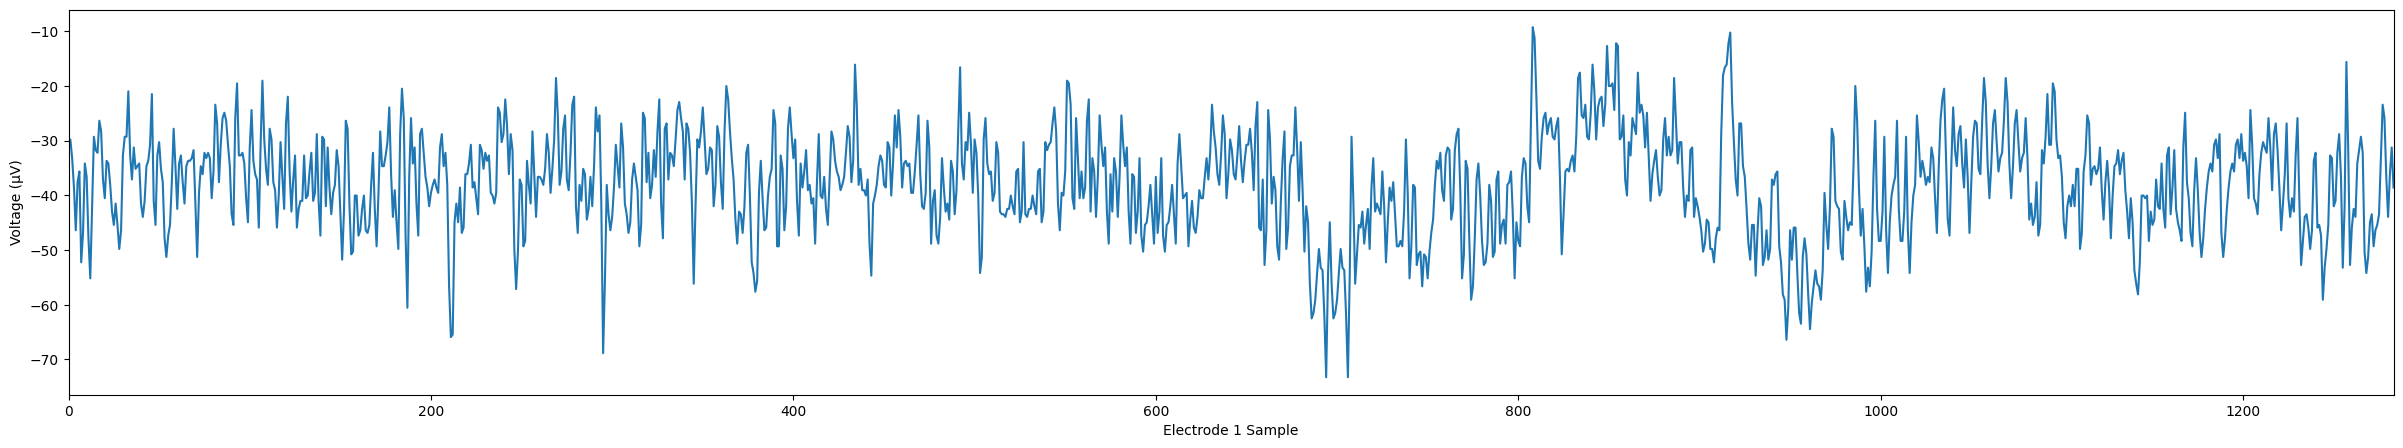

In [125]:
# Show a plot of the raw brainwave
time = np.arange(0, len(channel), 1)

plt.plot(time, channel)
plt.xlabel("Electrode 1 Sample")
plt.ylabel("Voltage (μV)")
plt.margins(x=0)
plt.show()

# Step 2:
Fast Fourier Transform

In [126]:
# Fourier transform
fftData = np.fft.fft(channel)
freq = np.fft.fftfreq(len(channel)) * SampleRate

# Now we just plot the transformed data (the exact same wave but in the frequency domain)
plotFreq    = freq[1:int(len(freq)/2)]                  # Remove negative reflection
plotFftData = fftData[1:int(len(fftData)/2)]            # Remove negative reflection
plotMag     = plotFftData.real**2 + plotFftData.imag**2 # FFT is a complex function, so we need to cast to the real domain

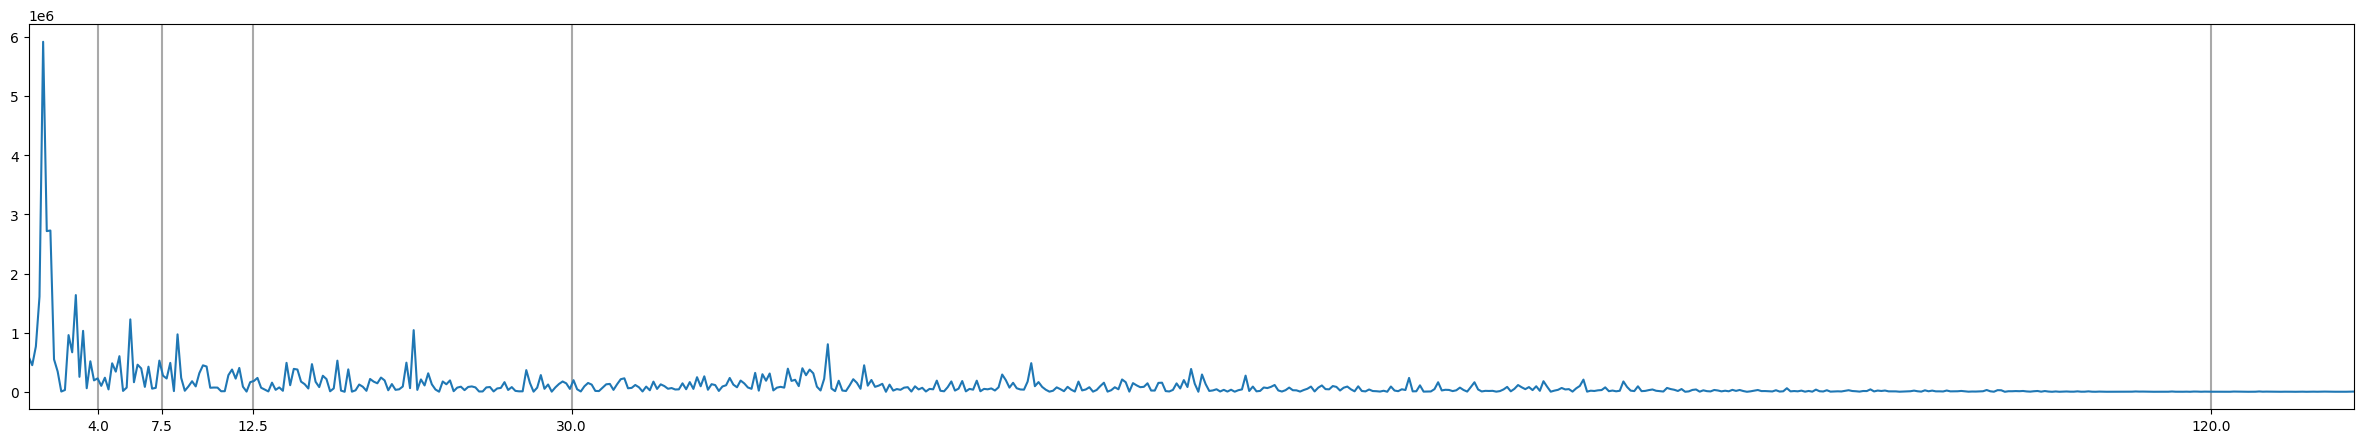

In [127]:
isShowingBinLines = True

# Create the plot
fig = plt.figure()
ax = fig.add_subplot()

# Add the special spacing
if(isShowingBinLines):
  subsets=[0, 4, 7.5, 12.5, 30, 120]
  ax.set_xticks(subsets)

# Add the vertical lines
if(isShowingBinLines):
  plt.axvline(x=4, color="darkgrey")
  plt.axvline(x=7.5, color="darkgrey")
  plt.axvline(x=12.5, color="darkgrey")
  plt.axvline(x=30, color="darkgrey")
  plt.axvline(x=120, color="darkgrey")

# Plot
ax.margins(x=0)
ax.plot(plotFreq, plotMag)
plt.show()

#Step 3:
Power Bins

In [128]:
# Bin the results
binsAverage = [0,0,0,0,0] # We will append to this later
binsTotal   = [0,0,0,0,0]
binsCount   = [0,0,0,0,0]

for point in range(len(plotFreq)):
  frequency = plotFreq[point]

  if(frequency < 4):      # Delta (0 - 4Hz)
    binsTotal[0] += plotMag[point]
    binsCount[0] += 1

  elif(frequency < 7.5):  # Theta (4 - 7.5Hz)
    binsTotal[1] += plotMag[point]
    binsCount[1] += 1

  elif(frequency < 12.5): # Alpha (7.5 - 12.5Hz)
    binsTotal[2] += plotMag[point]
    binsCount[2] += 1

  elif(frequency < 30):   # Beta  (12.5 - 30Hz)
    binsTotal[3] += plotMag[point]
    binsCount[3] += 1

  elif(frequency < 120):   # Gamma (30 - 120Hz)
    binsTotal[4] += plotMag[point]
    binsCount[4] += 1

# Compute the average for all of them
binsAverage = list(np.array(binsTotal)/np.array(binsCount))

print("Total:  ", binsTotal)
print("Count:  ", binsCount)
print("Average:", binsAverage)

Total:   [21246761.860118277, 5280566.181029631, 5535572.270117754, 11817974.303478997, 26478545.891842272]
Count:   [20, 17, 25, 88, 451]
Average: [1062338.0930059138, 310621.5400605665, 221422.89080471016, 134295.16253953407, 58710.744771268895]


#Step 3.5
Here we are going to move all of what we've written above into a function that we can use to easily run everything on our data later!

In [129]:
def getPowerBinsFromFilename(filename):
  if(str(type(filename)) != "<class 'str'>"): # Error handling
    print("Error: filename must be a string.")
    return


  ## Open the data ##
  channel = []
  with open(filename, "r") as data:
    for line in data:
        line = line.split(",")
        channel.append(float(line[1]))


  ## Fourier transform the data ##
  fftData = np.fft.fft(channel)
  freq = np.fft.fftfreq(len(channel)) * SampleRate

  outFftData = fftData[1:int(len(fftData)/2)]
  outMag     = outFftData.real**2 + outFftData.imag**2
  outFreq    = freq[1:int(len(freq)/2)]


  ## Bin the data ##
  binsTotal   = [0,0,0,0,0]
  binsCount   = [0,0,0,0,0]

  for point in range(len(outFreq)):
    frequency = outFreq[point]

    if(frequency < 4):      # Delta (0 - 4Hz)
      binsTotal[0] += outMag[point]
      binsCount[0] += 1

    elif(frequency < 7.5):  # Theta (4 - 7.5Hz)
      binsTotal[1] += outMag[point]
      binsCount[1] += 1

    elif(frequency < 12.5): # Alpha (7.5 - 12.5Hz)
      binsTotal[2] += outMag[point]
      binsCount[2] += 1

    elif(frequency < 30):   # Beta  (12.5 - 30Hz)
      binsTotal[3] += outMag[point]
      binsCount[3] += 1

    elif(frequency < 120):   # Gamma (30 - 120Hz)
      binsTotal[4] += outMag[point]
      binsCount[4] += 1

    binsAverage = [total / count if count != 0 else 0 for total, count in zip(binsTotal, binsCount)]

  # Finished computing the bins, return them
  return binsAverage




def showPlot(values, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(title, loc='left')
    ax.get_yaxis().set_visible(False)

    binNames = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    ax.bar(binNames, values, color=['#7967e1', '#527ae8', '#2689e7', '#0095e0', '#1b9fd6'])
    plt.show()




def showComparisonPlot(values):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title("Comparison", loc='left')
    ax.get_yaxis().set_visible(False)

    binNames = ['Sample A', 'Sample B']
    ax.bar(binNames, values, color=['#7967e1', '#1b9fd6'])
    plt.show()

#Step 4:
Classify!

# PREPROCESSING!!!!!!!!!!!!!!!!!!!!

In [150]:
import pandas as pd

def wave_to_df(bin, mood):
  wave_data = {
    "Delta" : bin[0],
    "Theta" : bin[1],
    "Alpha" : bin[2],
    "Beta" :  bin[3],
    "Gamma" : bin[4],
    "Mood" : mood
  }
  df = pd.DataFrame.from_dict([wave_data])
  return df
def append_to_df(df, bin, mood):
  wave_data = {
    "Delta" : bin[0],
    "Theta" : bin[1],
    "Alpha" : bin[2],
    "Beta" :  bin[3],
    "Gamma" : bin[4],
    "Mood" : mood
  }
  df_new = pd.DataFrame.from_dict([wave_data])
  frames = [df, df_new]
  df = pd.concat(frames)
  df = df.reset_index(drop=True)
  return df


def process_folder(folder_path, mood):
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Mood"])

    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Ensure only CSV files are processed
            file_path = os.path.join(folder_path, file_name)
            bins = getPowerBinsFromFilename(file_path)
            if df.empty:
                df = wave_to_df(bins, mood)
            else:
                df = append_to_df(df, bins, mood)

    return df


# Path to the folder
folder_path_happy = "NeuroTune/emotions_old/Happy"
folder_path_sad = "NeuroTune/emotions_old/Sad"
folder_path_angry = "NeuroTune/emotions_old/Angry"
folder_path_relaxed = "NeuroTune/emotions_old/Relaxed"

# Initialize an empty master DataFrame
master_df = pd.DataFrame(columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Mood"])

# Process each folder and append results to the master DataFrame

for folder_path, mood in [
    (folder_path_happy, "Happy"),
    (folder_path_sad, "Sad"),
    (folder_path_angry, "Angry"),
    (folder_path_relaxed, "Relaxed"),
]:
    folder_df = process_folder(folder_path, mood)
    master_df = pd.concat([master_df, folder_df], ignore_index=True)

# Display the resulting DataFrame
print(master_df)




           Delta         Theta         Alpha          Beta          Gamma  \
0   4.345471e+05  1.236701e+05  1.127263e+05  6.820599e+04   35017.369124   
1   9.276496e+05  4.976492e+05  3.710803e+05  8.049964e+05   80519.610096   
2   1.858106e+06  3.935786e+05  1.726914e+05  1.113870e+05   57465.377326   
3   1.338810e+06  6.565454e+05  4.747917e+05  1.067841e+06  109843.045751   
4   2.921054e+06  6.116421e+05  8.796155e+05  7.506881e+05  135639.106463   
5   1.420740e+06  8.097955e+05  3.710797e+05  7.834512e+05   93958.366691   
6   4.277663e+06  5.969791e+05  6.406988e+05  2.869051e+05   57456.699865   
7   3.548624e+06  4.824796e+05  2.552979e+05  1.192085e+05   34046.246735   
8   1.969140e+06  9.610376e+05  5.604415e+05  6.741669e+05   89951.338387   
9   1.082481e+07  3.882464e+05  2.538612e+05  9.419607e+05  104083.356521   
10  1.480226e+08  3.284862e+06  8.607868e+05  6.720782e+05  110853.005856   
11  9.388981e+06  1.002582e+06  2.805881e+05  1.234015e+06  122331.421691   

<ipython-input-150-70a3c976cd35>:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([master_df, folder_df], ignore_index=True)


# KAN!!!!!!!!!!!!!

In [151]:
!pip install pykan

In [152]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from kan import *
from kan.utils import create_dataset
from kan.utils import ex_round
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [153]:
#MOODS:
# Angry = 0
# Happy = 1
# Relaxed = 2
# Sad = 3

label_encoder = LabelEncoder()
master_df['Mood'] = label_encoder.fit_transform(master_df['Mood'])

#convert to tensors
# standardize brainwaves: z = (x - u) / s, helps with convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(master_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']].values)
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(master_df['Mood'].values, dtype=torch.long)

#test set = 20%, training set = 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dataset = {
    'train_input': X_train,
    'train_label': y_train,
    'test_input': X_test,
    'test_label': y_test
}

#define model with 5 input units, 16 hidden layer1 units, 8 hidden layer2 unites, 4 output units
#(multilayer KAN)
model = KAN(width=[5, 16, 8, 4], grid=3, k=3, seed=42, device=device)


checkpoint directory created: ./model
saving model version 0.0


In [154]:
#train model with CrossEntropyLoss for classification (epoch 1)
#model.fit(dataset, opt="Adam", steps=100, loss_fn=torch.nn.CrossEntropyLoss())
#model.fit(dataset, opt="Adam", steps=100, loss_fn=torch.nn.CrossEntropyLoss())


#accuracy calculations
def train_acc():
    predictions = torch.argmax(model(dataset['train_input']), dim=1)
    return torch.mean((predictions == dataset['train_label']).float())

def test_acc():
    predictions = torch.argmax(model(dataset['test_input']), dim=1)
    return torch.mean((predictions == dataset['test_label']).float())

In [155]:
#train again, calculate accuracy metrics at each step
results = model.fit(dataset, opt="Adam", steps=200, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
print("Final Train Accuracy:", results['train_acc'][-1])
print("Final Test Accuracy:", results['test_acc'][-1])

| train_loss: 0.00e+00 | test_loss: 3.15e+01 | reg: 2.24e+03 | : 100%|█| 200/200 [00:07<00:00, 25.70

saving model version 0.1
Final Train Accuracy: 0.9677419066429138
Final Test Accuracy: 0.75


In [156]:
# Print predictions as emotion strings
def print_predictions(data_input, data_label, label_encoder, dataset_type):
    predictions = torch.argmax(model(data_input), dim=1).numpy()
    actual_labels = data_label.numpy()

    # Decode numeric predictions and actual labels to strings
    decoded_predictions = label_encoder.inverse_transform(predictions)
    decoded_actual = label_encoder.inverse_transform(actual_labels)

    print(f"\n{dataset_type} Predictions:")
    for i in range(len(decoded_predictions)):
        print(f"Predicted: {decoded_predictions[i]}, Actual: {decoded_actual[i]}")



In [157]:
print_predictions(dataset['train_input'], dataset['train_label'], label_encoder, "Train")
print_predictions(dataset['test_input'], dataset['test_label'], label_encoder, "Test")


Train Predictions:
Predicted: Angry, Actual: Angry
Predicted: Sad, Actual: Sad
Predicted: Sad, Actual: Sad
Predicted: Happy, Actual: Happy
Predicted: Sad, Actual: Sad
Predicted: Sad, Actual: Sad
Predicted: Angry, Actual: Angry
Predicted: Sad, Actual: Sad
Predicted: Relaxed, Actual: Relaxed
Predicted: Happy, Actual: Happy
Predicted: Angry, Actual: Angry
Predicted: Happy, Actual: Happy
Predicted: Sad, Actual: Sad
Predicted: Happy, Actual: Happy
Predicted: Relaxed, Actual: Relaxed
Predicted: Angry, Actual: Angry
Predicted: Happy, Actual: Happy
Predicted: Relaxed, Actual: Relaxed
Predicted: Angry, Actual: Relaxed
Predicted: Happy, Actual: Happy
Predicted: Relaxed, Actual: Relaxed
Predicted: Angry, Actual: Angry
Predicted: Relaxed, Actual: Relaxed
Predicted: Sad, Actual: Sad
Predicted: Angry, Actual: Angry
Predicted: Sad, Actual: Sad
Predicted: Angry, Actual: Angry
Predicted: Happy, Actual: Happy
Predicted: Sad, Actual: Sad
Predicted: Angry, Actual: Angry
Predicted: Relaxed, Actual: Relaxe

In [158]:
# Assuming the necessary libraries (e.g., torch, scaler, label_encoder, etc.) are already imported

new_instance = 'Brainwaves_Happy_1.csv'

# Process the new instance to get bins
bin_avg = getPowerBinsFromFilename(new_instance)
print("Bin Averages:", bin_avg)

# Convert to tensor and add a batch dimension
bin_avg_scaled = scaler.transform([bin_avg])  # Transform expects 2D input
new_instance_tensor = torch.tensor(bin_avg_scaled, dtype=torch.float32).to(device)

# Pass the scaled instance through the model
logits = model(new_instance_tensor)

# Get the predicted class index
predicted_class_idx = torch.argmax(logits, dim=1).item()

# Decode the predicted index back to the emotion label
predicted_emotion = label_encoder.inverse_transform([predicted_class_idx])[0]

# Ensure that predicted_emotion is a string representing the class label
# Mapping index to emotion directly, since inverse_transform() will return string labels
print("Predicted Emotion: ", predicted_emotion)


Bin Averages: [1062338.0930059138, 310621.5400605665, 221422.89080471016, 134295.16253953407, 58710.744771268895]
Predicted Emotion:  Happy


/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

saving model version 0.2


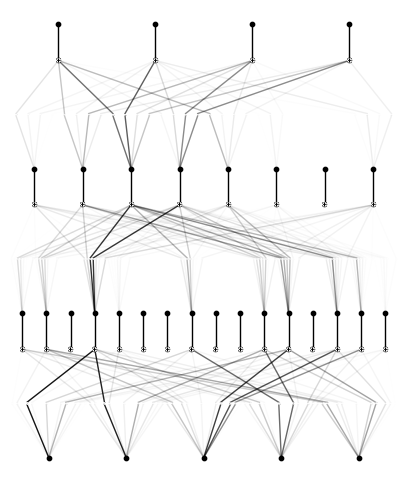

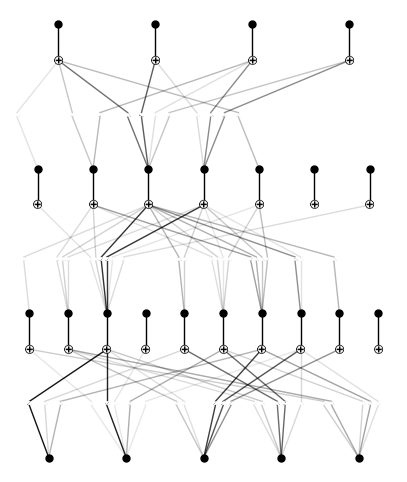

In [159]:
#plot model
model(dataset['train_input'])
model.plot()

#prune and plot model
model = model.prune()
model.plot()

In [140]:
print('-' * 50)
#find best fit function
mode = 'auto'  # can also do manual
#library of potential functions the model can use
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
#for each node it calculates the correlation between the function and the output. function with highest R is chosen
model.auto_symbolic(lib=lib)

formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)
print("\n Formula: ", formula)
print('-' * 50)

--------------------------------------------------
fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with sin, r2=0.9994227886199951, c=2
fixing (0,0,4) with 0
fixing (0,0,5) with sin, r2=0.9999898672103882, c=2
fixing (0,0,6) with sin, r2=0.9999895691871643, c=2
fixing (0,0,7) with sin, r2=0.9963949918746948, c=2
fixing (0,0,8) with 0
fixing (0,0,9) with x, r2=0.9705508947372437, c=1
fixing (0,0,10) with 0
fixing (0,0,11) with 0
fixing (0,0,12) with sin, r2=0.9998998641967773, c=2
fixing (0,1,0) with 0
fixing (0,1,1) with sin, r2=0.9997020959854126, c=2
fixing (0,1,2) with 0
fixing (0,1,3) with x^2, r2=0.9999853372573853, c=2
fixing (0,1,4) with 0
fixing (0,1,5) with sin, r2=0.9960519671440125, c=2
fixing (0,1,6) with 0
fixing (0,1,7) with x, r2=0.6441667079925537, c=1
fixing (0,1,8) with 0
fixing (0,1,9) with x, r2=0.7201492786407471, c=1
fixing (0,1,10) with tanh, r2=0.9994687438011169, c=3
fixing (0,1,11) with 0
fixing (0,1,12) with sin, r2=0.99974077